In [8]:
import cv2
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import scipy.stats as scip

In [9]:
def kmeans(img, kvalue):
    
    data = img.reshape((-1,3))
    
    k = kvalue


    # Number of training data
    n = data.shape[0]
    # Number of features in the data
    c = data.shape[1]

    #generate random centers to begin the KMeans analysis
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centers = np.random.randn(k,c)*std + mean


    clusters = np.zeros(n)
    distances = np.zeros((n,k))

    # Run through the KMeans algorithm 10 times
    for j in range(0,10):
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(data - centers[i], axis=1)

        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)

        # Calculate mean for every cluster and update the center
        for i in range(k):
            centers[i] = np.mean(data[clusters == i], axis=0)

    #colors used for segmentation - will not be seen in images, only in scatter plot if shown thus can basically be any color
    colors=['red', 'blue', 'green']

    for i in range(k):
        points = np.array([data[j] for j in range(len(data)) if clusters[j] == i])
           
        
    #create the output image from the clusters and the centers found through the kmeans algorithm
    centers = np.uint8(centers)
    returnImage = centers[clusters.flatten()]
    returnImage = returnImage.reshape((img.shape))

    #return both the image itself and the centers which will be used for the EM algorithm
    return(returnImage, centers)

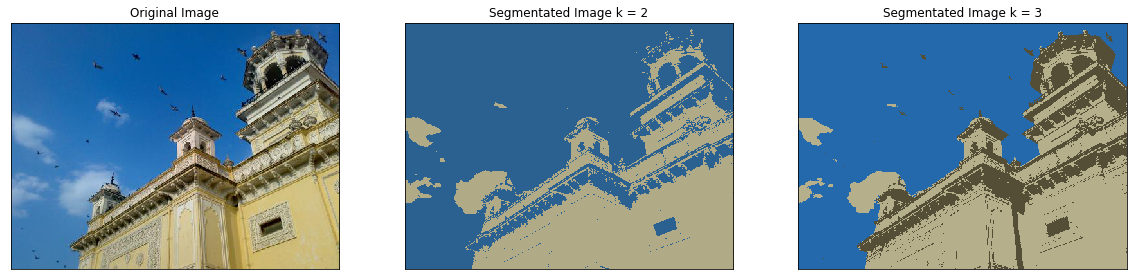

In [10]:
image = cv2.cvtColor(cv2.imread('home.jpg'), cv2.COLOR_BGR2RGB)

image2,_ = kmeans(image, 2)
image3,_ = kmeans(image, 3)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(image2)
plt.title("Segmentated Image k = 2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(image3)
plt.title("Segmentated Image k = 3"), plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
def init(image, k):
    
    #create one identity matrix with value of 100 for each iteration of k
    identityMatrices = np.array([np.identity(3)] * k)
    identityMatrices = identityMatrices*100
    
    #perform kmeans to initizlize the centers of the EM algorithm
    _, centers = kmeans(image, k)
    
    #generate random probabilities to begin EM
    ititialProbabilities = np.random.rand(k)
    
    #get the sum of all the randomized probabilities
    sumOfProbs = np.sum(ititialProbabilities)
    
    #divide all of the random probabilities by their sum so as to ensure that all probabilities sum to 1.0
    ititialProbabilities = ititialProbabilities / sumOfProbs

    return ititialProbabilities, centers, identityMatrices

In [12]:
def EMIteration(image, clusterProbs, centers, covariances, k):
    
    #obtain the number of pixels in the image
    numberOfPixels = image.shape[0]
    
    #first we will create a placeholder in which we will store the probability that each pixel is placed in each of the k options
    probabilityOfEachOption = np.array([np.zeros(numberOfPixels)]*k)
    
    #for each of the k options
    #compute the multivariate normal random variable of the image with the cluster center representing the mean and the covariance input as itself
    #from there, multiply the output by the input probability of each pixel being in each cluster to this point
    #using the scipy.stats.multivariate_normal.pdf function to perform multivariate normal calculation because the math was unruly. Will take the penalty here
    for i in range(0, k):
        mVN = scip.multivariate_normal.pdf(image, centers[i], covariances[i])
        probabilityOfEachOption[i] = clusterProbs[i]*mVN
    
    #sum the probability of each option so as to normalize the values before moving to M step
    sum_probabilityOfEachOption = np.sum(probabilityOfEachOption, axis=0)
    probabilityOfEachOption = probabilityOfEachOption / sum_probabilityOfEachOption
    
    #next, sum these normalized probabilities and divide that output by the total number of pixels
    weightOfEachOption = np.sum(probabilityOfEachOption, axis=1)
    clusterProbs = weightOfEachOption / numberOfPixels
    
    
    #create a placeholder for the centers for each color option
    centers = np.zeros((k, image.shape[1]))
    
    #calculate new centers for the clusters 
    for i in range(0, k):
        centers[i] = np.dot(probabilityOfEachOption[i], image) / weightOfEachOption[i]

    #create a placeholder for the covariances
    covariances = np.array([np.identity(3)*100] * k)
    
    #take the difference between the input image and the centers
    #then compute the covariances for this iteration
    for i in range(0, k):
        difference = image - centers[i]
        covariances[i] = np.dot(probabilityOfEachOption[i] * difference.T, difference) /  weightOfEachOption[i]
    
    return clusterProbs, centers, covariances, probabilityOfEachOption

In [13]:
def performEM(image, k):
    
    #reshape the image so that its size is simply the total number of pixels by the depth of the image (number of colours)
    reshapedImage = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))
    probabilities, centers, covariances = init(reshapedImage, k)
    
    #run through the ten iterations of the EM algorithm 
    for i in range(0, 10):
        probabilities, centers, covariances, probOfPixelForEachOption = EMIteration(reshapedImage, probabilities, centers , covariances, k)

    #as with the kmeans, we map the pixels as being in one of the sets as a final classification of the pixel
    #we will choose the highest probability option here unlike above
    clusters = np.argmax(probOfPixelForEachOption, axis = 0)
    
    #create the final image 
    #first reshape all of the clusters into the shape of an image and then place color into them to represent the different options
    finalImage = np.asarray(centers[clusters.reshape((image.shape[0], image.shape[1], 1))], dtype=np.uint8)
    finalImage = finalImage.reshape(image.shape)
    
    return(finalImage)

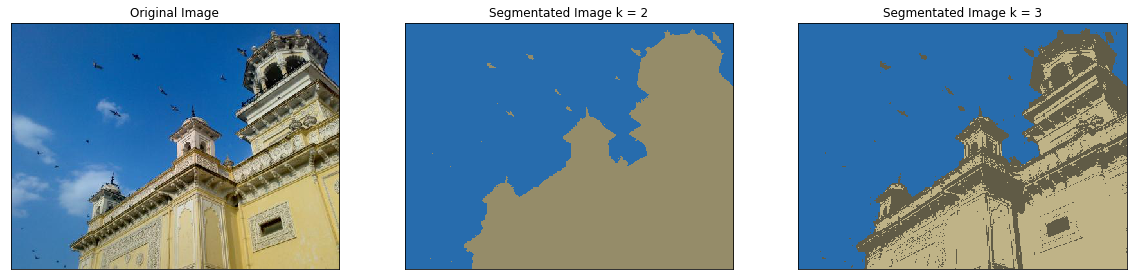

In [14]:
#intake the image and convert it to RGB
image = cv2.cvtColor(cv2.imread('home.jpg'), cv2.COLOR_BGR2RGB)


#perform the EM algorithm for both k=2 and k=3
EMK2 = performEM(image, 2)
EMK3 = performEM(image, 3)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(EMK2)
plt.title("Segmentated Image k = 2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(EMK3)
plt.title("Segmentated Image k = 3"), plt.xticks([]), plt.yticks([])
plt.show()

Given that the initializations of the two programs is the same, the EM algorithm would result in the same output as the KMeans algorithm in the situation where the covariances of the EM system were found to be 0. Covariance is a measure of how correlated two sets of data are to each other. In this case, if the EM covariances were found to be zero the algorithm would function much like the KMeans algorithm which - due to the fact that a single pixel can only be in one cluster or another - does not deal with a possibility of covariance like the EM one does.